In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedispersion
import filterbankio
import seaborn as sns

%matplotlib inline

In [2]:
sns.set()
sns.set_context("paper", rc={"lines.linewidth": 1.0})

In [3]:
B1900_01 = '/local/griffin/data/alfaburst/priorityModel/followup/B1900+01/Beam0_fb_D20150801T220510.buffer17.fil' # aslxlap
B1900_01 = '/home/griffin/data/alfa/followup/B1900+01/Beam0_fb_D20150801T220510.buffer17.fil' # watermark

In [4]:
fil = filterbankio.Filterbank(B1900_01)
timeFactor = 4
freqFactor = 1

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [5]:
dm = 245.

ddwaterfall = dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap') # apply dedispersion

waterfall = waterfall.reshape(waterfall.shape[0], waterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
ddwaterfall = ddwaterfall.reshape(ddwaterfall.shape[0], ddwaterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
freqsHz = freqsHz[::freqFactor]

In [6]:
#start_time = 0.
#time_window = 0.4
start_time = 0.1
time_window = 0.22

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

timeSeries = np.sum(waterfall, axis=1)
ddTimeSeries = np.sum(ddwaterfall, axis=1)

timeSeries = timeSeries[startIdx:endIdx]
ddTimeSeries = ddTimeSeries[startIdx:endIdx]
waterfall = waterfall[startIdx:endIdx,:]
ddwaterfall = ddwaterfall[startIdx:endIdx,:]

normTimeSeries = timeSeries / (waterfall.shape[1] * timeFactor)
normDDTimeSeries = ddTimeSeries / (waterfall.shape[1] * timeFactor)

In [7]:
# apply Gaussian filter
applyGauss = True
fGauss = 1. # bins
tGauss = 1. # bins

def gaussianFilter(arrShape, tSigma, fSigma):
    # Gaussian filter
    # arrShape: 2-D array shape
    # tSigma: sigma in time (ms)
    # fSigma: sigma in freq (MHz)
    lpos, mpos = np.mgrid[0:arrShape[0],0:arrShape[1]]
    taper = np.exp(-1. * ( (((lpos - (arrShape[0]/2.))**2.) / (2. * tSigma**2.)) + \
                           (((mpos - (arrShape[1]/2.))**2.) / (2. * fSigma**2.)) ))
    return taper

def convolveTaper(gaussImg, img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(gaussImg) * np.fft.fft2(img))).real

if applyGauss:
    gaussFilter = gaussianFilter(waterfall.shape, tGauss, fGauss)
    waterfall = convolveTaper(gaussFilter, waterfall)
    ddwaterfall = convolveTaper(gaussFilter, ddwaterfall)

In [8]:
# flatten bandpass
bandpass = np.tile(waterfall[80:].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#bandpass = np.tile(waterfall[:10].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
waterfallNorm = waterfall - bandpass
#waterfallNorm = waterfall

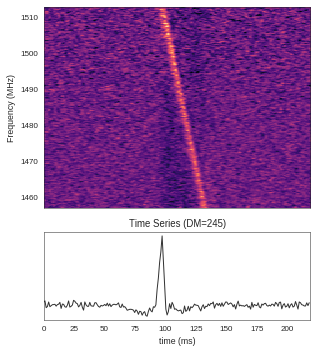

In [9]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(4.5,5)) # (width, height)
#fig = plt.figure(figsize=(5,6)) # (width, height)
#fig = plt.figure(figsize=(7,5)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
#plt.subplot(2,1,1)
imRaw = plt.imshow(np.flipud(waterfallNorm.T), extent=(0, tInt * waterfall.shape[0] * 1000., fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
#imRaw = plt.imshow(np.flipud(bandpass.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

#plt.title('B1900+01')
plt.ylabel('Frequency (MHz)')
#cax = fig.add_axes([0.75, .95, 0.15, 0.03])
#cbar = fig.colorbar(imRaw, cax=cax, orientation='horizontal')
#cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation='vertical', fontsize=8)
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
#plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(tInt * np.arange(waterfall.shape[0]) * 1000., normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt * timeSeries.shape[0] * 1000.)
plt.title('Time Series (DM=%0.f)'%dm)
plt.xlabel('time (ms)')
ax2.get_yaxis().set_visible(False)
#plt.ylabel('Amp')

#plt.subplots_adjust(hspace=-0.3)
plt.tight_layout()

plt.savefig('../figures/B1900_01.pdf')